In [15]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.sampler import load_users, calculate_degrees
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter
from tqdm import tqdm
import subprocess
import numpy as np

In [16]:
TWIBOT_DIR = "/Users/komalchandiramani/Desktop/NUS/s2/graphml/Group Project/data/TwiBot-22/"
SAMPLED_DIR = "/Users/komalchandiramani/Desktop/NUS/s2/graphml/Group Project/data/static/"
os.makedirs("plots", exist_ok=True)

pd.set_option('display.float_format', '{:.2f}'.format)

In [17]:
### Load the original TwiBot-22 data
users_df = load_users(TWIBOT_DIR)
users_df = calculate_degrees(TWIBOT_DIR, users_df)
users_df['time_bin'] = pd.qcut(
        users_df['created_at'], 
        q=20, 
        labels=False, 
        duplicates='drop'
    )


### Load the subsampled TwiBot-22 data
users_sampled_df = pd.read_csv(SAMPLED_DIR+"sampled_user_ids.csv")
users_sampled_df["created_at"] = pd.to_datetime(users_sampled_df["created_at"])

Loaded 1,000,000 labels
Processing 1,000,000 users


  Processing users: 100%|██████████| 11/11 [00:04<00:00,  2.61chunk/s]


Loaded 1,000,000 users
  Humans: 860,057
  Bots: 139,943
Calculating degrees


  Processing edges: 1702chunk [01:38, 17.24chunk/s]


In [18]:
print(f"No of users in the TwiBot-22 dataset: {users_df.shape[0]}")
print(f"No of users sampled from the TwiBot-22 dataset: {users_sampled_df.shape[0]}")

No of users in the TwiBot-22 dataset: 1000000
No of users sampled from the TwiBot-22 dataset: 21359


# Human - Bot Distribution

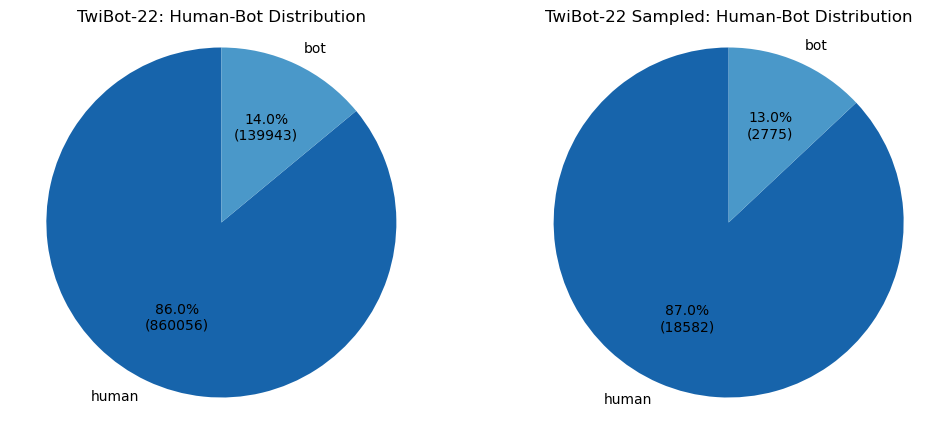

In [19]:
### Compare the Human-Bot distribution b/w the full dataset and the subsampled dataset
users_label_counts = users_df['label'].value_counts(normalize=True)
users_label_raw = users_df['label'].value_counts()
users_sampled_label_counts = users_sampled_df['label'].value_counts(normalize=True)
users_sampled_label_raw = users_sampled_df['label'].value_counts()
cmap = cm.get_cmap("Blues")
colors = [cmap(0.8), cmap(0.6)]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pie(users_label_counts, labels = users_label_counts.index, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100 * users_label_raw.sum())})", startangle=90, colors=colors)
axes[0].set_title("TwiBot-22: Human-Bot Distribution")
axes[0].axis('equal')
axes[1].pie(users_sampled_label_counts, labels = users_sampled_label_counts.index, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100 * users_sampled_label_raw.sum())})", startangle=90, colors=colors)
axes[1].set_title("TwiBot-22 Sampled: Human-Bot Distribution")
axes[1].axis('equal')
plt.savefig("./plots/human_bot_distbn.png")
plt.show()

The sampled dataset contains 21,359 users of which 87\% are humans and 13\% are bots. This closely matches the full dataset's split, indicating that label balance is preserved by our sampling strategy.

# User Account Creation Distribution

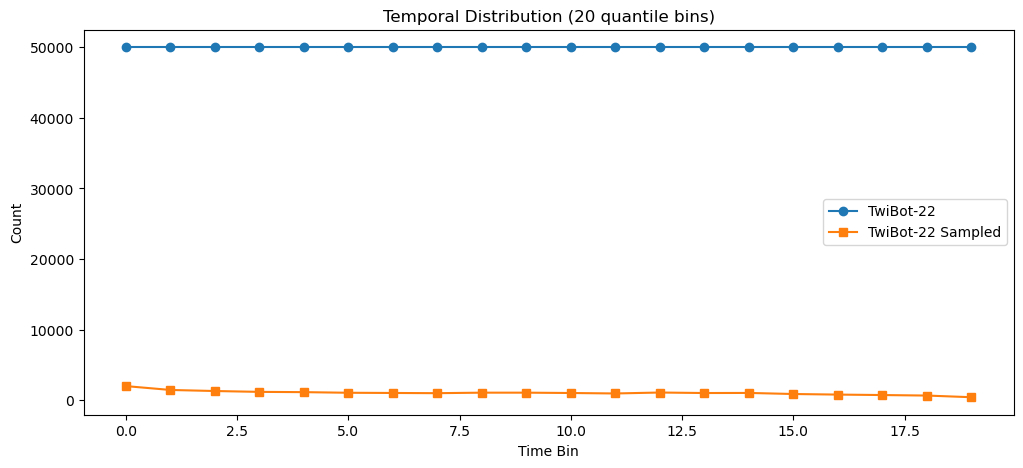

In [20]:
### Compare the user account creation b/w the full dataset and the subsampled dataset
orig_bins = users_df.groupby('time_bin').size()
samp_bins = users_sampled_df.groupby('time_bin').size()

plt.figure(figsize=(12,5))
plt.plot(orig_bins.index, orig_bins.values, marker="o", label="TwiBot-22")
plt.plot(samp_bins.index, samp_bins.values, marker="s", label="TwiBot-22 Sampled")
plt.title("Temporal Distribution (20 quantile bins)")
plt.xlabel("Time Bin")
plt.ylabel("Count")
plt.legend()
plt.savefig("./plots/temporal_distbn.png")
plt.show()


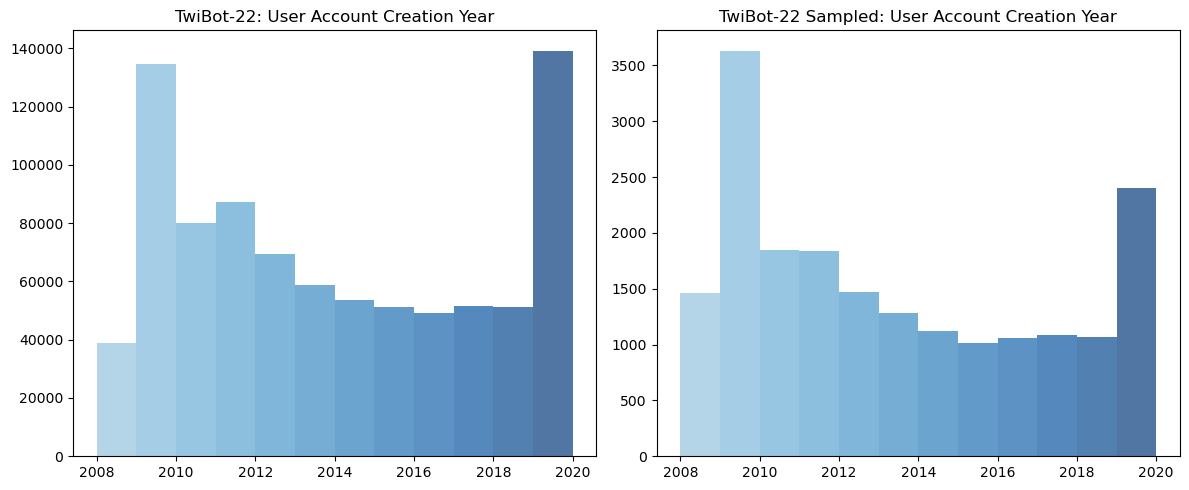

In [21]:
users_df['year'] = users_df['created_at'].dt.year
users_sampled_df['year'] = users_sampled_df['created_at'].dt.year

start = int(users_df["year"].quantile(0.05))
end = int(users_df["year"].quantile(0.95))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
counts, bins, patches = plt.hist(users_df['year'], bins=range(start,end), alpha=0.7)
for i, p in enumerate(patches):
    p.set_facecolor(cmap(0.4 + 0.6 * (i / len(patches))))
plt.title("TwiBot-22: User Account Creation Year")

plt.subplot(1,2,2)
counts2, bins2, patches2 = plt.hist(users_sampled_df['year'], bins=range(start,end), alpha=0.7)
for i, p in enumerate(patches2):
    p.set_facecolor(cmap(0.4 + 0.6 * (i / len(patches2))))
plt.title("TwiBot-22 Sampled: User Account Creation Year")

plt.tight_layout()
plt.savefig("./plots/temporal_distbn_hist.png")
plt.show()



The temporal distribution of account creation years in the sampled dataset closely mirrors that of the full TwiBot-22 user population 

# User Degree Distribution

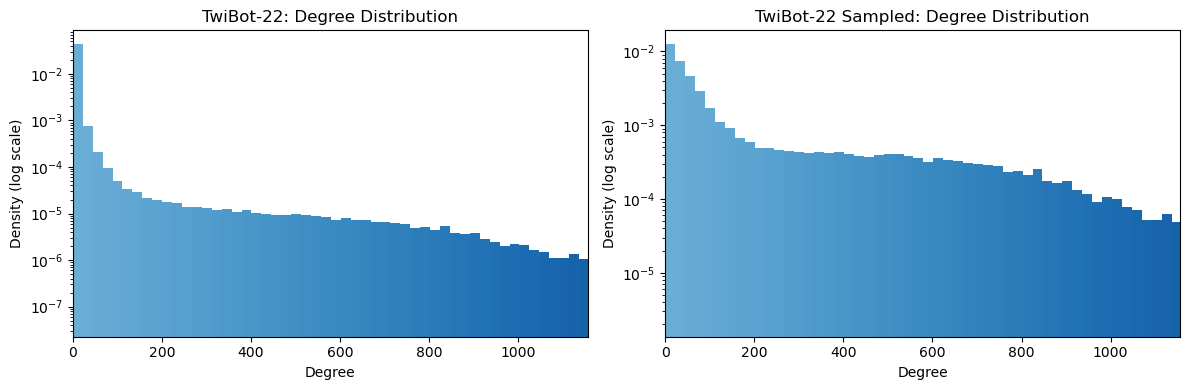

In [22]:
plt.figure(figsize=(12,4))

# Original
plt.subplot(1,2,1)
counts, bins, patches = plt.hist(users_df['degree'], bins=100, density=True,)
for i, p in enumerate(patches):
    p.set_facecolor(cmap(0.5 + 0.6 * (i / len(patches))))
plt.yscale("log")
plt.xlim(0, users_sampled_df['degree'].quantile(0.99))
plt.xlabel("Degree")
plt.ylabel("Density (log scale)")
plt.title("TwiBot-22: Degree Distribution")


plt.subplot(1,2,2)
counts2, bins2, patches2 = plt.hist(users_sampled_df['degree'], bins=100, density=True,)
for i, p in enumerate(patches2):
    p.set_facecolor(cmap(0.5 + 0.6 * (i / len(patches2))))
plt.yscale("log")
plt.xlim(0, users_sampled_df['degree'].quantile(0.99))
plt.xlabel("Degree")
plt.ylabel("Density (log scale)")
plt.title("TwiBot-22 Sampled: Degree Distribution")

plt.tight_layout()
plt.savefig("./plots/degree_distbn_hist.png")
plt.show()
